The data has been collected from Kaggle. Source: https://www.kaggle.com/c/rossmann-store-sales/data <br> <br>
**Goal:** Predicting 6 weeks of daily sales for 1,115 stores located across Germany.

In [0]:
#Rossman Sales Prediction-Kaggle
#Importing libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import operator
import matplotlib
import matplotlib.pyplot as plt



In [0]:

def build_features(features, data):
    # replacing nan with 0
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
   
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Number of months promo is open
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data



In [30]:
from google.colab import files
uploaded = files.upload()

Saving store.csv to store (1).csv


In [14]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "test.csv" with length 1427426 bytes


In [27]:
import pandas as pd
import io
train_data = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')), parse_dates=[2] )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
test_data = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')), parse_dates = [3])

In [0]:
store = pd.read_csv(io.StringIO(uploaded['store.csv'].decode('utf-8')))

In [32]:

types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}


Load the training, test and store data using pandas


In [33]:
#Loading train_data,test_data and store data

train_data.fillna(1, inplace=True)
test_data.fillna(1, inplace=True)


train_data = train_data[train_data["Open"] != 0]

train_data = train_data[train_data["Sales"] > 0]

print("Join with store")
train_data = pd.merge(train_data, store, on='Store')
test_data = pd.merge(test_data, store, on='Store')

features = []

print("augment features")
build_features(features, train_data)
build_features([], test_data)
print(features)
print('train_dataing data processed')


unique = test_data.Store.unique()
train_data = train_data[train_data['Store'].isin(unique)]

# Lets split data into train_data and validation
X_train_data, X_valid = train_data_test_data_split(train_data, test_data_size=0.012, random_state=10)
y_train_data = np.log1p(X_train_data.Sales)
y_valid = np.log1p(X_valid.Sales)

def rmspe(y, yhat):
    return np.sqrt(np.mean(((y-yhat)/y) ** 2))



Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero. Simplifies calculation of rmspe
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed


Train a XGBoost model
[0]	train-rmse:6.61142	eval-rmse:6.61014	train-rmspe:0.998709	eval-rmspe:0.998705
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:5.29293	eval-rmse:5.29255	train-rmspe:0.994739	eval-rmspe:0.994731
[2]	train-rmse:4.23908	eval-rmse:4.23901	train-rmspe:0.984622	eval-rmspe:0.984603
[3]	train-rmse:3.39626	eval-rmse:3.39704	train-rmspe:0.964243	eval-rmspe:0.964222
[4]	train-rmse:2.7232	eval-rmse:2.72421	train-rmspe:0.929986	eval-rmspe:0.929974
[5]	train-rmse:2.18587	eval-rmse:2.18687	train-rmspe:0.88037	eval-rmspe:0.880321
[6]	train-rmse:1.75765	eval-rmse:1.759	train-rmspe:0.816756	eval-rmspe:0.816745
[7]	train-rmse:1.41678	eval-rmse:1.41832	train-rmspe:0.742973	eval-rmspe:0.742984
[8]	train-rmse:1.14626	eval-rmse:1.14819	train-rmspe:0.664164	eval-rmspe:0.664261
[9]	train-rmse:0.932211	eval-rmse:0.934478	train-rmspe:0.585675	eval-rmspe:0.585885
[10]	train-rms

[141]	train-rmse:0.094227	eval-rmse:0.103973	train-rmspe:0.104577	eval-rmspe:0.112201
[142]	train-rmse:0.094089	eval-rmse:0.103902	train-rmspe:0.104423	eval-rmspe:0.112133
[143]	train-rmse:0.093918	eval-rmse:0.103842	train-rmspe:0.104245	eval-rmspe:0.112091
[144]	train-rmse:0.093738	eval-rmse:0.103738	train-rmspe:0.10402	eval-rmspe:0.111987
[145]	train-rmse:0.093516	eval-rmse:0.10356	train-rmspe:0.10378	eval-rmspe:0.11182
[146]	train-rmse:0.09337	eval-rmse:0.103432	train-rmspe:0.103632	eval-rmspe:0.111621
[147]	train-rmse:0.093205	eval-rmse:0.103321	train-rmspe:0.103463	eval-rmspe:0.111546
[148]	train-rmse:0.092844	eval-rmse:0.103047	train-rmspe:0.103101	eval-rmspe:0.111263
[149]	train-rmse:0.092681	eval-rmse:0.102962	train-rmspe:0.102942	eval-rmspe:0.111177
[150]	train-rmse:0.092518	eval-rmse:0.102858	train-rmspe:0.10261	eval-rmspe:0.110731
[151]	train-rmse:0.092306	eval-rmse:0.102631	train-rmspe:0.10232	eval-rmspe:0.110622
[152]	train-rmse:0.092032	eval-rmse:0.102402	train-rmspe:0.10

[282]	train-rmse:0.07753	eval-rmse:0.094724	train-rmspe:0.082742	eval-rmspe:0.102325
[283]	train-rmse:0.077501	eval-rmse:0.094714	train-rmspe:0.082709	eval-rmspe:0.102332
[284]	train-rmse:0.07742	eval-rmse:0.094683	train-rmspe:0.082587	eval-rmspe:0.102299
[285]	train-rmse:0.077319	eval-rmse:0.094686	train-rmspe:0.082449	eval-rmspe:0.102288
[286]	train-rmse:0.077249	eval-rmse:0.094669	train-rmspe:0.082376	eval-rmspe:0.102283
[287]	train-rmse:0.077138	eval-rmse:0.094611	train-rmspe:0.082259	eval-rmspe:0.102231
[288]	train-rmse:0.07709	eval-rmse:0.094584	train-rmspe:0.082202	eval-rmspe:0.102208
[289]	train-rmse:0.077012	eval-rmse:0.094546	train-rmspe:0.08211	eval-rmspe:0.102199
[290]	train-rmse:0.07694	eval-rmse:0.094496	train-rmspe:0.082021	eval-rmspe:0.102146
[291]	train-rmse:0.076842	eval-rmse:0.094443	train-rmspe:0.081908	eval-rmspe:0.102174
[292]	train-rmse:0.076719	eval-rmse:0.094387	train-rmspe:0.081766	eval-rmspe:0.102113
[293]	train-rmse:0.076631	eval-rmse:0.094317	train-rmspe:0.

[423]	train-rmse:0.068978	eval-rmse:0.091923	train-rmspe:0.072445	eval-rmspe:0.101339
[424]	train-rmse:0.068917	eval-rmse:0.091893	train-rmspe:0.072378	eval-rmspe:0.101301
[425]	train-rmse:0.068853	eval-rmse:0.091946	train-rmspe:0.072278	eval-rmspe:0.101372
[426]	train-rmse:0.068801	eval-rmse:0.091942	train-rmspe:0.072222	eval-rmspe:0.101369
[427]	train-rmse:0.068761	eval-rmse:0.091928	train-rmspe:0.07218	eval-rmspe:0.101357
[428]	train-rmse:0.068731	eval-rmse:0.091921	train-rmspe:0.072143	eval-rmspe:0.101349
[429]	train-rmse:0.06868	eval-rmse:0.091895	train-rmspe:0.072089	eval-rmspe:0.101286
[430]	train-rmse:0.068626	eval-rmse:0.091857	train-rmspe:0.072032	eval-rmspe:0.101251
[431]	train-rmse:0.068605	eval-rmse:0.091841	train-rmspe:0.072011	eval-rmspe:0.101221
[432]	train-rmse:0.068573	eval-rmse:0.091842	train-rmspe:0.071974	eval-rmspe:0.101212
[433]	train-rmse:0.068529	eval-rmse:0.091863	train-rmspe:0.071919	eval-rmspe:0.101233
[434]	train-rmse:0.068494	eval-rmse:0.091885	train-rmspe

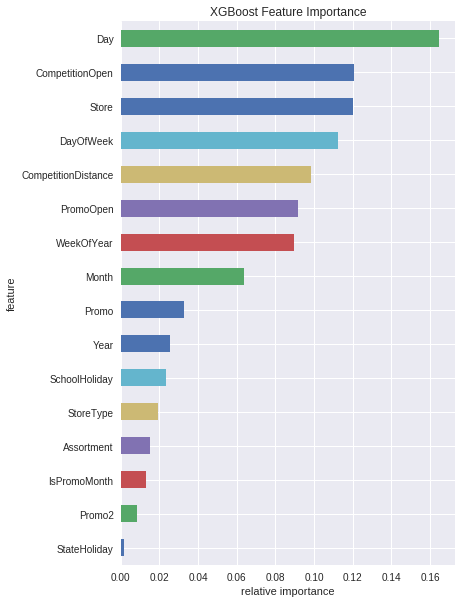

In [45]:

#Model building - XG Boost

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 10,
          "subsample": 0.80,
          "colsample_bytree": 0.75,
          "silent": 1,
          "seed": 1
          }
num_boost_round = 450 #number of iterations


def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label()) 
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)



dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_val[features], y_val)

wl = [(dtrain, 'train'), (dvalid, 'eval')]
print("Train a XGBoost model")
gbm = xgb.train(params, dtrain, num_boost_round, evals=wl, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_val[features]))
error = rmspe(X_val.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))
#RMSPE - Root Mean Square Percentage Error 

test['StateHoliday'] = test['StateHoliday'].astype('int32')
print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)



#feature importances

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)



In [46]:
test_probs.shape

(41088,)

In [47]:
final_pred = np.expm1(test_probs)

result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result = result.sort_values(['Id'], ascending=[True])
print(result.head())

ds = result["Sales"]
with open("out.csv", "w") as subfile:  
    subfile.write("Id,Sales\n")
    for i, pred in enumerate(list(ds)):
        subfile.write("%s,%s\n"%(result.iloc[i,0],result.iloc[i,1]))

files.download('out.csv')

     Id        Sales
0     1  4383.696777
48    2  7488.126465
96    3  9118.330078
144   4  6783.677734
192   5  7385.319824


When submitted on Kaggle the output was 0.12018 (rsmpe).